In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, auc, roc_curve
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


A few tweaks on CSS to make tables look better...

In [2]:
CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
"""

In [3]:
## Magics and commom settings
pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline

pd.set_option("display.max_columns",7)

from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))

## Reading data

The data provided by Kaggle is comprised of 8 CSV files, with a main train/test file with reference to all the other files through the SK_xxx columns. The file *"HomeCredit_columns_description.csv"* contains information about each column in each file.

In [4]:
!dir data

 O volume na unidade C não tem nome.
 O Número de Série do Volume é D8D6-4768

 Pasta de C:\Users\braian.dias\datascience\machine-learning\projects\capstone\home_credit\data

28/08/2018  15:10    <DIR>          .
28/08/2018  15:10    <DIR>          ..
13/08/2018  17:06        26.567.651 application_test.csv
13/08/2018  17:06       166.133.370 application_train.csv
13/08/2018  17:06       170.016.717 bureau.csv
13/08/2018  17:06       375.592.889 bureau_balance.csv
13/08/2018  17:06       424.582.605 credit_card_balance.csv
28/08/2018  15:10           172.475 exploratory_analysis.twb
13/08/2018  17:06            37.383 HomeCredit_columns_description.csv
13/08/2018  17:05       723.118.349 installments_payments.csv
13/08/2018  17:06       392.703.158 POS_CASH_balance.csv
13/08/2018  17:06       404.973.293 previous_application.csv
13/08/2018  17:06           536.202 sample_submission.csv
              11 arquivo(s)  2.684.434.092 bytes
               2 pasta(s)   177.083.310.080 bytes di

In [5]:
# READ all .csv files
app_test = pd.read_csv("data/application_test.csv")
app_train = pd.read_csv("data/application_train.csv")
bureau = pd.read_csv("data/bureau.csv")
bureau_balance = pd.read_csv("data/bureau_balance.csv")
previous_application = pd.read_csv("data/previous_application.csv")
POS_CASH_balance = pd.read_csv("data/POS_CASH_balance.csv")
credit_card_balance = pd.read_csv("data/credit_card_balance.csv")
installments_payments = pd.read_csv("data/installments_payments.csv")

In [6]:
# Create a new dataframe containing basic stats about each file
cols = ["file_name","columns","rows"]
file_stats = pd.DataFrame(columns = cols)
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["application_train.csv",app_train.shape[1],app_train.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["application_test.csv",app_test.shape[1],app_test.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["bureau.csv",bureau.shape[1],bureau.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["bureau_balance.csv",bureau_balance.shape[1],bureau_balance.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["credit_card_balance.csv",credit_card_balance.shape[1],credit_card_balance.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["installments_payments.csv",installments_payments.shape[1],installments_payments.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["POS_CASH_balance.csv",POS_CASH_balance.shape[1],POS_CASH_balance.shape[0]]]),columns=cols)])
file_stats = pd.concat([file_stats,pd.DataFrame(np.array([["previous_application.csv",previous_application.shape[1],previous_application.shape[0]]]),columns=cols)])
file_stats = file_stats.reset_index(drop=True)

NameError: name 'bureau' is not defined

In [ ]:
#Set dataframes to None to free memory after we have calculated the basic statistics for all files
POS_CASH_balance = None
credit_card_balance = None
installments_payments = None
previous_application = None
bureau = None
bureau_balance = None

file_stats.to_csv("file_stats.csv",index=False)

Below is a summary of all 8 files available : 1 main file for training (with target) 1 main file for testing (without the target), and 6 other files containing additional information about each loan.

In [ ]:
file_stats

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).
The test data folows the same structure, but it has 48744 observations and lacks the TARGET column.

We can see the first 5 observations of the main training data below :

In [6]:
app_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,...,0.0000,0.0000,1.0000
1,100003,0,Cash loans,...,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,...,0.0000,0.0000,0.0000
3,100006,0,Cash loans,...,nan,nan,nan
4,100007,0,Cash loans,...,0.0000,0.0000,0.0000
5,100008,0,Cash loans,...,0.0000,1.0000,1.0000
6,100009,0,Cash loans,...,1.0000,1.0000,2.0000
7,100010,0,Cash loans,...,0.0000,0.0000,0.0000
8,100011,0,Cash loans,...,0.0000,0.0000,1.0000
9,100012,0,Revolving loans,...,nan,nan,nan


It's possible to see that the two first columns are a identifier column (key) and the target variable, respectivelly. From now on those two columns will be removed from the analysis.

In [7]:
features = app_train.columns[2:]

## Dataset description and statistics 

### Distribution of target data

It seems that data is skewed, we have much more label 0 than label 1

Number of training instances with TARGET 0 : 282686
Number of training instances with TARGET 1 : 24825


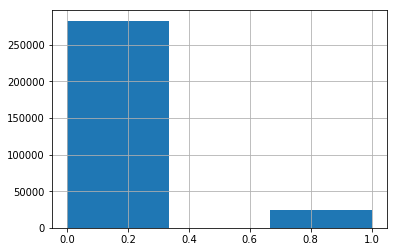

In [8]:
app_train['TARGET'].hist(bins=3)

print('Number of training instances with TARGET 0 : {}'.format(app_train[app_train['TARGET']<=0].shape[0]))
print('Number of training instances with TARGET 1 : {}'.format(app_train[app_train['TARGET']>0].shape[0]))

Separating the features in the main file in **numerical** and **non-numerical** features in order to calculate statistics about the data 

In [9]:
non_numerical_features = [col for col in app_train[features].columns if app_train[col].dtype == 'object']    
text_binary_features = []

numerical_features     = [col for col in app_train[features].columns if app_train[col].dtype != 'object']
#Breaking numerical features into int and float
int_features     = [col for col in app_train[numerical_features].columns if app_train[col].dtype == 'int64']
int_binary_features = []    
float_features   = [col for col in app_train[numerical_features].columns if app_train[col].dtype != 'int64']

print("There are {} NON-numerical features in the main dataset.".format(len(non_numerical_features)))
print("There are {} numerical features in the main dataset.".format(len(numerical_features)))
print("\t{} are Int64 features".format(len(int_features)))
print("\t{} are Float64 features".format(len(float_features)))

There are 16 NON-numerical features in the main dataset.
There are 104 numerical features in the main dataset.
	39 are Int64 features
	65 are Float64 features


### Numerical features


Below is the list of numerical features and the description of the data

In [10]:
print("List of Int64 features : {}".format(app_train[int_features].columns))
app_train[int_features].describe()

List of Int64 features : Index([u'CNT_CHILDREN', u'DAYS_BIRTH', u'DAYS_EMPLOYED', u'DAYS_ID_PUBLISH',
       u'FLAG_MOBIL', u'FLAG_EMP_PHONE', u'FLAG_WORK_PHONE',
       u'FLAG_CONT_MOBILE', u'FLAG_PHONE', u'FLAG_EMAIL',
       u'REGION_RATING_CLIENT', u'REGION_RATING_CLIENT_W_CITY',
       u'HOUR_APPR_PROCESS_START', u'REG_REGION_NOT_LIVE_REGION',
       u'REG_REGION_NOT_WORK_REGION', u'LIVE_REGION_NOT_WORK_REGION',
       u'REG_CITY_NOT_LIVE_CITY', u'REG_CITY_NOT_WORK_CITY',
       u'LIVE_CITY_NOT_WORK_CITY', u'FLAG_DOCUMENT_2', u'FLAG_DOCUMENT_3',
       u'FLAG_DOCUMENT_4', u'FLAG_DOCUMENT_5', u'FLAG_DOCUMENT_6',
       u'FLAG_DOCUMENT_7', u'FLAG_DOCUMENT_8', u'FLAG_DOCUMENT_9',
       u'FLAG_DOCUMENT_10', u'FLAG_DOCUMENT_11', u'FLAG_DOCUMENT_12',
       u'FLAG_DOCUMENT_13', u'FLAG_DOCUMENT_14', u'FLAG_DOCUMENT_15',
       u'FLAG_DOCUMENT_16', u'FLAG_DOCUMENT_17', u'FLAG_DOCUMENT_18',
       u'FLAG_DOCUMENT_19', u'FLAG_DOCUMENT_20', u'FLAG_DOCUMENT_21'],
      dtype='object')


,CNT_CHILDREN,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
count,307511.0000,307511.0000,307511.0000,...,307511.0000,307511.0000,307511.0000
mean,0.4171,-16036.9951,63815.0459,...,0.0006,0.0005,0.0003
std,0.7221,4363.9886,141275.7665,...,0.0244,0.0225,0.0183
min,0.0000,-25229.0000,-17912.0000,...,0.0000,0.0000,0.0000
25%,0.0000,-19682.0000,-2760.0000,...,0.0000,0.0000,0.0000
50%,0.0000,-15750.0000,-1213.0000,...,0.0000,0.0000,0.0000
75%,1.0000,-12413.0000,-289.0000,...,0.0000,0.0000,0.0000
max,19.0000,-7489.0000,365243.0000,...,1.0000,1.0000,1.0000


There are some categorical features (e.g: FLAG_xxx features are binary features) that are coded as 0 and 1 (Int64) but in fact they are categorical. We're going to remove them from the numerical features and store in another variable called *int_binary_features*.

In [11]:
int_binary_features = ['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12',
       'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15',
       'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18',
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

int_features = [col for col in int_features if col not in int_binary_features]
numerical_features = [col for col in numerical_features if col not in int_binary_features]

In [12]:
print("List of Float64 features : {}".format(app_train[float_features].columns))
app_train[float_features].describe()

List of Float64 features : Index([u'AMT_INCOME_TOTAL', u'AMT_CREDIT', u'AMT_ANNUITY', u'AMT_GOODS_PRICE',
       u'REGION_POPULATION_RELATIVE', u'DAYS_REGISTRATION', u'OWN_CAR_AGE',
       u'CNT_FAM_MEMBERS', u'EXT_SOURCE_1', u'EXT_SOURCE_2', u'EXT_SOURCE_3',
       u'APARTMENTS_AVG', u'BASEMENTAREA_AVG', u'YEARS_BEGINEXPLUATATION_AVG',
       u'YEARS_BUILD_AVG', u'COMMONAREA_AVG', u'ELEVATORS_AVG',
       u'ENTRANCES_AVG', u'FLOORSMAX_AVG', u'FLOORSMIN_AVG', u'LANDAREA_AVG',
       u'LIVINGAPARTMENTS_AVG', u'LIVINGAREA_AVG', u'NONLIVINGAPARTMENTS_AVG',
       u'NONLIVINGAREA_AVG', u'APARTMENTS_MODE', u'BASEMENTAREA_MODE',
       u'YEARS_BEGINEXPLUATATION_MODE', u'YEARS_BUILD_MODE',
       u'COMMONAREA_MODE', u'ELEVATORS_MODE', u'ENTRANCES_MODE',
       u'FLOORSMAX_MODE', u'FLOORSMIN_MODE', u'LANDAREA_MODE',
       u'LIVINGAPARTMENTS_MODE', u'LIVINGAREA_MODE',
       u'NONLIVINGAPARTMENTS_MODE', u'NONLIVINGAREA_MODE', u'APARTMENTS_MEDI',
       u'BASEMENTAREA_MEDI', u'YEARS_BEGINEXPLUA

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.0000,307511.0000,307499.0000,...,265992.0000,265992.0000,265992.0000
mean,168797.9193,599025.9997,27108.5739,...,0.2674,0.2655,1.9000
std,237123.1463,402490.7770,14493.7373,...,0.9160,0.7941,1.8693
min,25650.0000,45000.0000,1615.5000,...,0.0000,0.0000,0.0000
25%,112500.0000,270000.0000,16524.0000,...,0.0000,0.0000,0.0000
50%,147150.0000,513531.0000,24903.0000,...,0.0000,0.0000,1.0000
75%,202500.0000,808650.0000,34596.0000,...,0.0000,0.0000,3.0000
max,117000000.0000,4050000.0000,258025.5000,...,27.0000,261.0000,25.0000


### percentage of null (NaN) among numerical variables

In [13]:
def null_count(dataframe):
    null = dataframe.isnull().sum()
    
    columns = null.index.values
    null_count = null.values
    null_stats = pd.DataFrame({'column' : columns, 'null_count': null_count})
    null_stats['total_rows'] = dataframe.shape[0]
    null_stats['perc_null'] = (null_stats['null_count'] / null_stats['total_rows']) * 100
    null_stats = null_stats[null_stats['null_count']> 0]
    null_stats = null_stats.sort_values(by=['null_count'],ascending=False)
    
    return null_stats

Number of features (numerical) with missing values : 61


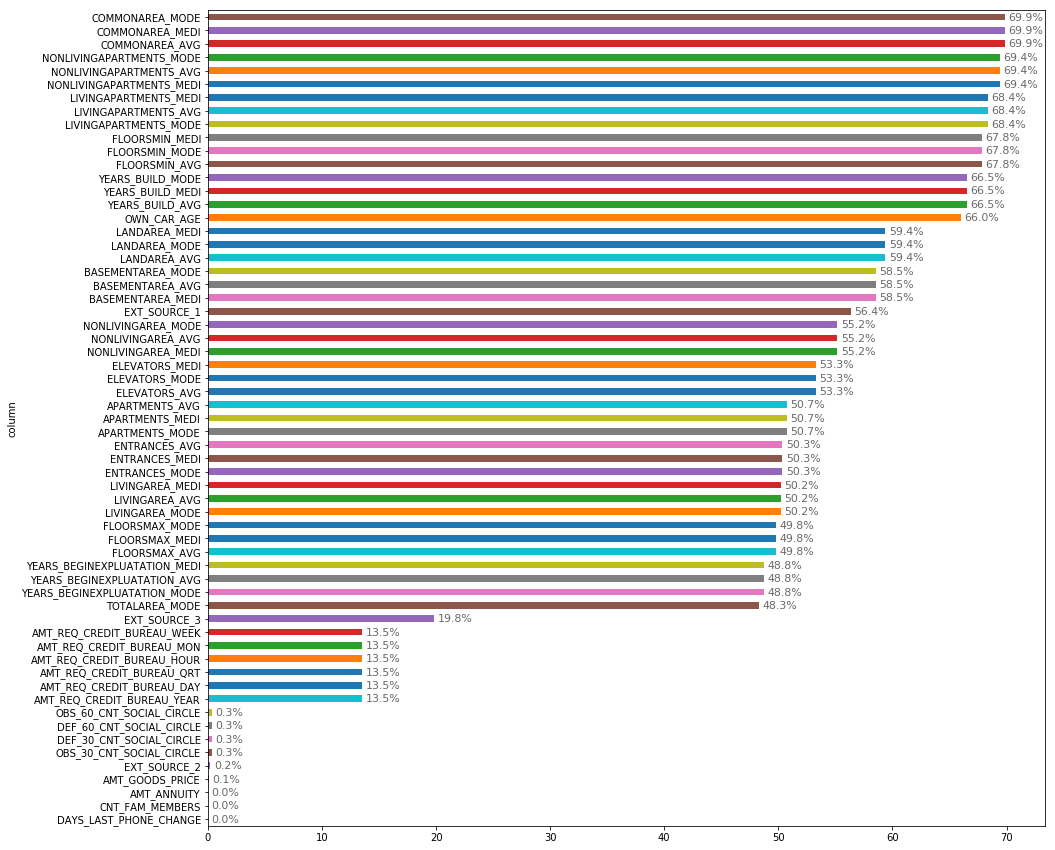

In [14]:
null_numerical = null_count(app_train[numerical_features])
print 'Number of features (numerical) with missing values : {}'.format(null_numerical.shape[0])
null_numerical.head(10)

null_numerical = null_numerical.sort_values(by="perc_null")
null_numerical = null_numerical.reset_index(drop=True)

ax = null_numerical.plot(kind="barh",x="column",y="perc_null",figsize=(15,15),legend=False)
for i,patch in enumerate(ax.patches):
    # get_width pulls left or right; get_y pushes up or down
    ax.text(patch.get_width()+.3, patch.get_y(), \
            str(round(null_numerical.loc[i,"perc_null"],1))+'%', fontsize=11,
color='dimgrey')

In [15]:
null_int_binary = null_count(app_train[int_binary_features])
null_int_binary

,column,null_count,total_rows,perc_null


It seems boolean data coded in (0,1) is complete :).

### Non-numerical features


In [16]:
print("There are {} non-numerical features : {}".format(len(non_numerical_features),app_train[non_numerical_features].columns))
app_train[non_numerical_features].describe()

There are 16 non-numerical features : Index([u'NAME_CONTRACT_TYPE', u'CODE_GENDER', u'FLAG_OWN_CAR',
       u'FLAG_OWN_REALTY', u'NAME_TYPE_SUITE', u'NAME_INCOME_TYPE',
       u'NAME_EDUCATION_TYPE', u'NAME_FAMILY_STATUS', u'NAME_HOUSING_TYPE',
       u'OCCUPATION_TYPE', u'WEEKDAY_APPR_PROCESS_START', u'ORGANIZATION_TYPE',
       u'FONDKAPREMONT_MODE', u'HOUSETYPE_MODE', u'WALLSMATERIAL_MODE',
       u'EMERGENCYSTATE_MODE'],
      dtype='object')


,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,...,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,...,153214,151170,161756
unique,2,3,2,...,3,7,2
top,Cash loans,F,N,...,block of flats,Panel,No
freq,278232,202448,202924,...,150503,66040,159428


In [17]:
null_non_numerical = null_count(app_train[non_numerical_features])
null_non_numerical

,column,null_count,total_rows,perc_null
12,FONDKAPREMONT_MODE,210295,307511,68.3862
14,WALLSMATERIAL_MODE,156341,307511,50.8408
13,HOUSETYPE_MODE,154297,307511,50.1761
15,EMERGENCYSTATE_MODE,145755,307511,47.3983
9,OCCUPATION_TYPE,96391,307511,31.3455
4,NAME_TYPE_SUITE,1292,307511,0.4201


### binary variables

We can see from the data above that the features EMERGENCYSTATE_MODE has only two possible values (yes/no). However, we're going to treat it as it has more than 2 categories, once we're going to introduce a new category to represent the null values.

The list of binary features is defined below:

In [18]:
text_binary_features = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY']

non_numerical_features = [col for col in non_numerical_features if col not in text_binary_features]

Looking at the statistics above we start to see some aspects of the data that would be interesting to adjust:
* Some categorical features have too many levels (e.g: OCCUPATION_TYPE has 18, ORGANIZATION_TYPE has 58)
* Some of them have null data

### Person Correlation Coefficient

In [19]:
corr_target = app_train.corr()["TARGET"]

In [20]:
top_corr = pd.DataFrame(corr_target.abs().sort_values(ascending=False).head(11))
top_corr

,TARGET
TARGET,1.0000
EXT_SOURCE_3,0.1789
EXT_SOURCE_2,0.1605
EXT_SOURCE_1,0.1553
DAYS_BIRTH,0.0782
REGION_RATING_CLIENT_W_CITY,0.0609
REGION_RATING_CLIENT,0.0589
DAYS_LAST_PHONE_CHANGE,0.0552
DAYS_ID_PUBLISH,0.0515
REG_CITY_NOT_WORK_CITY,0.0510


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001EDFB320>,
      dtype=object)

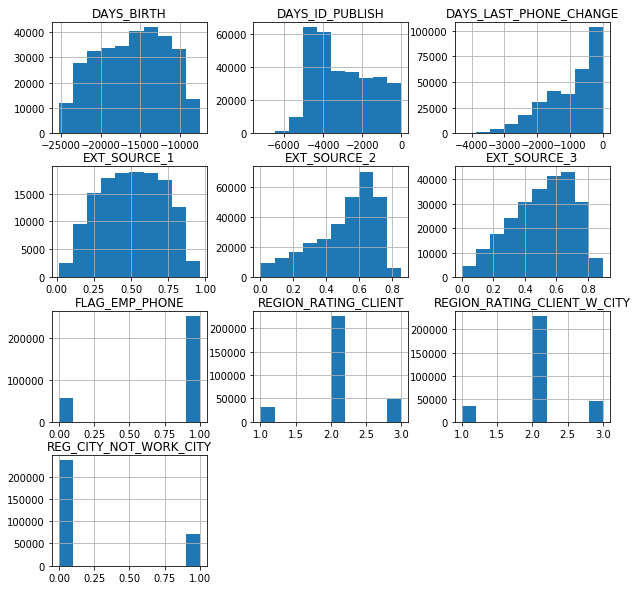

In [21]:
app_train[top_corr.index[1:]].hist(figsize=(10,10))

## Data Preparation

### Label encoding for discrete features

For features with 2 or more levels, where going to perform one-hot encoding.
For binary features, we're going to perform label encoding.
But before that, null values will be placed in a new category called 'NOT_INF' (short for 'not informed').

In [22]:
#binary features
label_encoder = LabelEncoder()
for col in text_binary_features:
    label_encoder.fit(app_train[col])
    app_train[col] = label_encoder.transform(app_train[col])
    app_test[col] = label_encoder.transform(app_test[col])

In [23]:
#add NOT_INF to NaN values in categorical features
for feat in non_numerical_features:
    app_train.at[app_train[feat].isnull(),[feat]] = 'NOT_INF'
    app_test.at[app_test[feat].isnull(),[feat]] = 'NOT_INF'

In [24]:
#one-hot encoding for categorical features with more than 2 unique values
categorical_data_train = pd.get_dummies(app_train[non_numerical_features])
categorical_data_test  = pd.get_dummies(app_test[non_numerical_features])
one_hot_features = categorical_data_train.columns
app_train = pd.concat([app_train,categorical_data_train],axis=1)
app_test  = pd.concat([app_test,categorical_data_test],axis=1)
### remove the raw columns
app_train = app_train.drop(columns=non_numerical_features)
app_test  = app_test.drop(columns=non_numerical_features)

In [25]:
print app_train.shape
print app_test.shape

(307511, 249)
(48744, 245)


### Data alignment

In [26]:
train_targets = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Recover the target variable that was dropped during the alignment
app_train['TARGET'] = train_targets

In [27]:
features = app_train.columns[1:245].values

### Outliers

In [28]:
app_train['DAYS_BIRTH'].describe()

count   307511.0000
mean    -16036.9951
std       4363.9886
min     -25229.0000
25%     -19682.0000
50%     -15750.0000
75%     -12413.0000
max      -7489.0000
Name: DAYS_BIRTH, dtype: float64

In [29]:
app_train['DAYS_EMPLOYED'].describe()

count   307511.0000
mean     63815.0459
std     141275.7665
min     -17912.0000
25%      -2760.0000
50%      -1213.0000
75%       -289.0000
max     365243.0000
Name: DAYS_EMPLOYED, dtype: float64

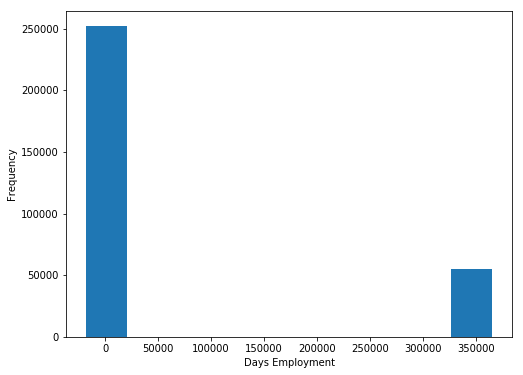

In [30]:
app_train['DAYS_EMPLOYED'].plot.hist(figsize=(8,6));
plt.xlabel('Days Employment');

In [31]:
anomaly = app_train[app_train['DAYS_EMPLOYED'] >= 300000]
print('There are %d anomalous days of employment' % len(anomaly))

There are 55374 anomalous days of employment


In [32]:
app_train['DAYS_EMPLOYED_OLD'] = app_train["DAYS_EMPLOYED"]

app_train['DAYS_EMPLOYED_OUTL'] = app_train["DAYS_EMPLOYED"] >= 300000
app_train.at[app_train['DAYS_EMPLOYED_OUTL']==True,'DAYS_EMPLOYED'] = np.nan

app_test['DAYS_EMPLOYED_OUTL'] = app_test["DAYS_EMPLOYED"] >= 300000
app_test.at[app_test['DAYS_EMPLOYED_OUTL']==True,'DAYS_EMPLOYED'] = np.nan

label_encoder = LabelEncoder()
label_encoder.fit(app_train['DAYS_EMPLOYED_OUTL'])
app_train['DAYS_EMPLOYED_OUTL'] = label_encoder.transform(app_train['DAYS_EMPLOYED_OUTL'])
app_test['DAYS_EMPLOYED_OUTL'] = label_encoder.transform(app_test['DAYS_EMPLOYED_OUTL'])



In [33]:
features = np.append(features,'DAYS_EMPLOYED_OUTL')

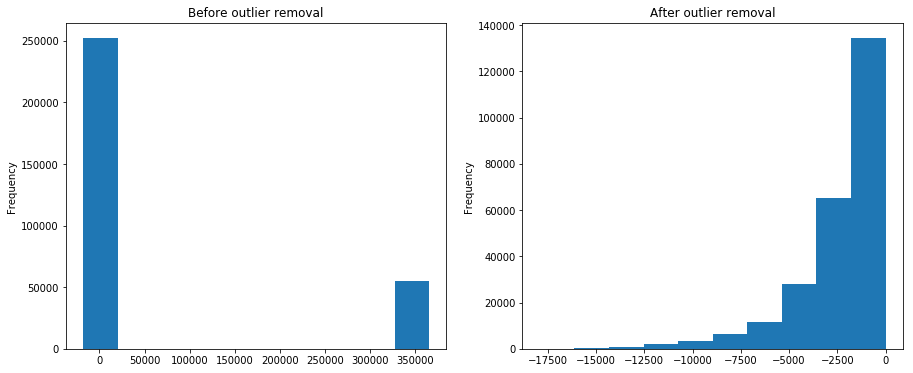

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,6))

app_train['DAYS_EMPLOYED_OLD'].plot.hist(ax=ax[0],title="Before outlier removal");
app_train['DAYS_EMPLOYED'].plot.hist(ax=ax[1],title="After outlier removal")


In [35]:
app_train = app_train.drop(columns=['DAYS_EMPLOYED_OLD'])

### Dealing with missing data

In [36]:
app_train_no_null = app_train.copy()

null_feat = (features for features in numerical_features \
                 if app_train_no_null.loc[app_train_no_null[features].isnull(),[features]].shape[0]>0)
for feat in null_feat:
    app_train_no_null.at[app_train_no_null[feat].isnull(),[feat]] = np.nanmedian(app_train_no_null[feat])


In [37]:
app_test_no_null = app_test.copy()

null_feat = (features for features in numerical_features \
                 if app_test_no_null.loc[app_test_no_null[features].isnull(),[features]].shape[0]>0)
for feat in null_feat:
    app_test_no_null.at[app_test_no_null[feat].isnull(),[feat]] = np.nanmedian(app_test_no_null[feat])


### basic functions

In [38]:
def save_results_to_submit(predictions,id=[],filename=None):
    sk_id_curr = None
    if len(id)==0:
        sk_id_curr = app_test['SK_ID_CURR'].values
    else:
        sk_id_curr = id
        
    submission_result = pd.DataFrame({'SK_ID_CURR' : sk_id_curr ,'TARGET' : predictions})
    submission_result[submission_result['TARGET']==0]
    if filename != None:
        submission_result.to_csv(filename,index=False)
        print("predictions saved : {}".format(filename))

In [39]:
def train_test_classifier(train_df,features,clf,test_size=0.25):
    time_start = time.time()

    X = train_df[features]
    Y = train_df['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = test_size,random_state = 50)
    clf.fit(X_train,y_train)

    prediction = clf.predict(X_test)
    #score = cross_val_score(base_model, X, Y, scoring='roc_auc', cv = 10)

    print('Model trained in {} seconds'.format(time.time()-time_start))
    #print('AUC of Random Forest is : {} '.format(np.mean(score)))
    print('Validation AUC score of {:.4f}.').format(roc_auc_score(y_true=y_test,y_score=prediction))
    
    return clf, X_train, X_test, y_train, y_test, prediction

In [51]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(12,8))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

def train_test_cv(clf,X,y):
    time_start = time.time()
    
    cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])
    fprs, tprs, scores = [], [], []

    for (train, test), i in zip(cv.split(X, y), range(5)):
        clf.fit(X.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf)
        fpr, tpr, auc_score = compute_roc_auc(test,clf)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        
    print('Model trained in {} seconds'.format(time.time()-time_start))
        
    return clf,fprs, tprs,pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])


### Training the baseline model

In [92]:
X = app_train_no_null[features]
y = app_train_no_null['TARGET']
base_model_rfcv = RandomForestClassifier(random_state = 50)
base_model_rfcv , fprs_rfcv, tprs_rfcv, results_rfcv = train_test_cv(base_model_rfcv,X,y)
results_rfcv

Model trained in 76.9014289379 seconds


,AUC Train,AUC Test
0,0.9998,0.6253
1,0.9998,0.6310
2,0.9998,0.6378
3,0.9998,0.6344
4,0.9998,0.6303


In [99]:
results_rfcv.mean()

AUC Train   0.9998
AUC Test    0.6318
dtype: float64

In [95]:
pred_basemodel_rfcv = base_model_rfcv.predict_proba(app_test_no_null[features])[:, 1]
save_results_to_submit(pred_basemodel_rfcv,filename="random_forest_base_cv.csv")

predictions saved : random_forest_base_cv.csv


### XGBOOST with NaN values

In [96]:
X = app_train[features]
y = app_train['TARGET']
xgboost_cv = XGBClassifier(random_state=50)
xgboost_cv , fprs_xgb, tprs_xgb_xgb, results_xgb = train_test_cv(xgboost_cv,X,y)
results_xgb

Model trained in 707.351706028 seconds


,AUC Train,AUC Test
0,0.7596,0.7502
1,0.7602,0.7483
2,0.7590,0.7541
3,0.7600,0.7511
4,0.7601,0.7526


In [100]:
results_xgb.mean()

AUC Train   0.7598
AUC Test    0.7513
dtype: float64

In [97]:
pred_xgboost_cv = xgboost_cv.predict_proba(app_test[features])[:, 1]
save_results_to_submit(pred_xgboost_cv,filename="xgboost_cv.csv")

predictions saved : xgboost_cv.csv


### Optimization : Grid search

#### 1. Random Forest Optimization

In [101]:
time_start = time.time()

# Create hyperparameter options
parameters = {'max_depth': [None,10, 50],
              'min_samples_leaf': [1, 4],
              'n_estimators': [50, 100, 200]}

X = app_train_no_null[features]
Y = app_train_no_null['TARGET']
base_model = RandomForestClassifier(random_state=50)

grid_obj = GridSearchCV(estimator=base_model,
                        param_grid=parameters,
                        scoring='roc_auc',
                        verbose=10,
                        n_jobs=3)

grid_obj = grid_obj.fit(X, Y)

best_rf = grid_obj.best_estimator_
y_train_rf_opt = best_rf.predict(app_train_no_null[features])

print('Tuned model has a training AUC score of {:.4f}.').format(roc_auc_score(y_true=Y,y_score=y_train_rf_opt))
print('Grid search took {} seconds to run'.format(time.time()-time_start))

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] n_estimators=50, max_depth=None, min_samples_leaf=1 .............
[CV] n_estimators=50, max_depth=None, min_samples_leaf=1 .............
[CV] n_estimators=50, max_depth=None, min_samples_leaf=1 .............
[CV]  n_estimators=50, max_depth=None, min_samples_leaf=1, score=0.691274 - 1.1min
[CV] n_estimators=100, max_depth=None, min_samples_leaf=1 ............
[CV]  n_estimators=50, max_depth=None, min_samples_leaf=1, score=0.695992 - 1.5min
[CV] n_estimators=100, max_depth=None, min_samples_leaf=1 ............


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.5min


[CV]  n_estimators=50, max_depth=None, min_samples_leaf=1, score=0.693184 - 1.5min
[CV] n_estimators=100, max_depth=None, min_samples_leaf=1 ............
[CV]  n_estimators=100, max_depth=None, min_samples_leaf=1, score=0.710908 - 2.7min
[CV] n_estimators=200, max_depth=None, min_samples_leaf=1 ............
[CV]  n_estimators=100, max_depth=None, min_samples_leaf=1, score=0.708976 - 2.7min
[CV] n_estimators=200, max_depth=None, min_samples_leaf=1 ............
[CV]  n_estimators=100, max_depth=None, min_samples_leaf=1, score=0.707526 - 3.1min
[CV] n_estimators=200, max_depth=None, min_samples_leaf=1 ............
[CV]  n_estimators=200, max_depth=None, min_samples_leaf=1, score=0.715522 - 5.5min
[CV] n_estimators=50, max_depth=None, min_samples_leaf=4 .............


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  9.8min


[CV]  n_estimators=200, max_depth=None, min_samples_leaf=1, score=0.720345 - 5.9min
[CV] n_estimators=50, max_depth=None, min_samples_leaf=4 .............
[CV]  n_estimators=200, max_depth=None, min_samples_leaf=1, score=0.716560 - 5.2min
[CV] n_estimators=50, max_depth=None, min_samples_leaf=4 .............
[CV]  n_estimators=50, max_depth=None, min_samples_leaf=4, score=0.714629 -  56.4s
[CV] n_estimators=100, max_depth=None, min_samples_leaf=4 ............
[CV]  n_estimators=50, max_depth=None, min_samples_leaf=4, score=0.719763 - 1.2min
[CV] n_estimators=100, max_depth=None, min_samples_leaf=4 ............
[CV]  n_estimators=50, max_depth=None, min_samples_leaf=4, score=0.715816 - 1.3min
[CV] n_estimators=100, max_depth=None, min_samples_leaf=4 ............


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 11.2min


[CV]  n_estimators=100, max_depth=None, min_samples_leaf=4, score=0.725225 - 1.8min
[CV] n_estimators=200, max_depth=None, min_samples_leaf=4 ............
[CV]  n_estimators=100, max_depth=None, min_samples_leaf=4, score=0.729444 - 2.7min
[CV] n_estimators=200, max_depth=None, min_samples_leaf=4 ............
[CV]  n_estimators=100, max_depth=None, min_samples_leaf=4, score=0.725619 - 2.6min
[CV] n_estimators=200, max_depth=None, min_samples_leaf=4 ............
[CV]  n_estimators=200, max_depth=None, min_samples_leaf=4, score=0.734246 - 4.3min
[CV] n_estimators=50, max_depth=10, min_samples_leaf=1 ...............
[CV]  n_estimators=50, max_depth=10, min_samples_leaf=1, score=0.729457 -  37.8s
[CV] n_estimators=50, max_depth=10, min_samples_leaf=1 ...............
[CV]  n_estimators=200, max_depth=None, min_samples_leaf=4, score=0.729961 - 4.8min
[CV] n_estimators=50, max_depth=10, min_samples_leaf=1 ...............
[CV]  n_estimators=200, max_depth=None, min_samples_leaf=4, score=0.73024

[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 18.4min


[CV]  n_estimators=50, max_depth=10, min_samples_leaf=1, score=0.726218 -  38.3s
[CV] n_estimators=100, max_depth=10, min_samples_leaf=1 ..............
[CV]  n_estimators=50, max_depth=10, min_samples_leaf=1, score=0.727620 -  26.7s
[CV] n_estimators=100, max_depth=10, min_samples_leaf=1 ..............
[CV]  n_estimators=100, max_depth=10, min_samples_leaf=1, score=0.731667 -  59.0s
[CV] n_estimators=200, max_depth=10, min_samples_leaf=1 ..............
[CV]  n_estimators=100, max_depth=10, min_samples_leaf=1, score=0.729152 - 1.2min
[CV] n_estimators=200, max_depth=10, min_samples_leaf=1 ..............
[CV]  n_estimators=100, max_depth=10, min_samples_leaf=1, score=0.730563 - 1.2min
[CV] n_estimators=200, max_depth=10, min_samples_leaf=1 ..............
[CV]  n_estimators=200, max_depth=10, min_samples_leaf=1, score=0.731305 - 1.8min
[CV] n_estimators=50, max_depth=10, min_samples_leaf=4 ...............
[CV]  n_estimators=200, max_depth=10, min_samples_leaf=1, score=0.732612 - 2.2min
[C

[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 21.5min


[CV]  n_estimators=50, max_depth=10, min_samples_leaf=4, score=0.729376 -  26.0s
[CV] n_estimators=50, max_depth=10, min_samples_leaf=4 ...............
[CV]  n_estimators=50, max_depth=10, min_samples_leaf=4, score=0.729937 -  40.0s
[CV] n_estimators=100, max_depth=10, min_samples_leaf=4 ..............
[CV]  n_estimators=200, max_depth=10, min_samples_leaf=1, score=0.732337 - 2.4min
[CV] n_estimators=100, max_depth=10, min_samples_leaf=4 ..............
[CV]  n_estimators=50, max_depth=10, min_samples_leaf=4, score=0.727066 -  31.6s
[CV] n_estimators=100, max_depth=10, min_samples_leaf=4 ..............
[CV]  n_estimators=100, max_depth=10, min_samples_leaf=4, score=0.730618 -  49.6s
[CV] n_estimators=200, max_depth=10, min_samples_leaf=4 ..............
[CV]  n_estimators=100, max_depth=10, min_samples_leaf=4, score=0.732054 - 1.2min
[CV] n_estimators=200, max_depth=10, min_samples_leaf=4 ..............
[CV]  n_estimators=100, max_depth=10, min_samples_leaf=4, score=0.731173 - 1.3min
[CV

[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 25.5min


[CV]  n_estimators=200, max_depth=10, min_samples_leaf=4, score=0.732386 - 2.4min
[CV] n_estimators=50, max_depth=50, min_samples_leaf=1 ...............
[CV]  n_estimators=50, max_depth=50, min_samples_leaf=1, score=0.699971 - 1.6min
[CV] n_estimators=100, max_depth=50, min_samples_leaf=1 ..............
[CV]  n_estimators=50, max_depth=50, min_samples_leaf=1, score=0.691451 - 1.0min
[CV] n_estimators=100, max_depth=50, min_samples_leaf=1 ..............
[CV]  n_estimators=50, max_depth=50, min_samples_leaf=1, score=0.690869 - 1.5min
[CV] n_estimators=100, max_depth=50, min_samples_leaf=1 ..............
[CV]  n_estimators=100, max_depth=50, min_samples_leaf=1, score=0.713839 - 2.1min
[CV] n_estimators=200, max_depth=50, min_samples_leaf=1 ..............
[CV]  n_estimators=100, max_depth=50, min_samples_leaf=1, score=0.705963 - 3.1min
[CV] n_estimators=200, max_depth=50, min_samples_leaf=1 ..............
[CV]  n_estimators=100, max_depth=50, min_samples_leaf=1, score=0.708104 - 3.1min
[CV

[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 33.7min


[CV]  n_estimators=50, max_depth=50, min_samples_leaf=4, score=0.717057 - 1.1min
[CV] n_estimators=50, max_depth=50, min_samples_leaf=4 ...............
[CV]  n_estimators=200, max_depth=50, min_samples_leaf=1, score=0.717056 - 5.3min
[CV] n_estimators=100, max_depth=50, min_samples_leaf=4 ..............
[CV]  n_estimators=200, max_depth=50, min_samples_leaf=1, score=0.714445 - 5.6min
[CV] n_estimators=100, max_depth=50, min_samples_leaf=4 ..............
[CV]  n_estimators=50, max_depth=50, min_samples_leaf=4, score=0.716525 - 1.3min
[CV] n_estimators=100, max_depth=50, min_samples_leaf=4 ..............
[CV]  n_estimators=100, max_depth=50, min_samples_leaf=4, score=0.729019 - 2.5min
[CV] n_estimators=200, max_depth=50, min_samples_leaf=4 ..............
[CV]  n_estimators=100, max_depth=50, min_samples_leaf=4, score=0.725657 - 2.4min
[CV] n_estimators=200, max_depth=50, min_samples_leaf=4 ..............
[CV]  n_estimators=100, max_depth=50, min_samples_leaf=4, score=0.726536 - 2.4min
[C

[Parallel(n_jobs=3)]: Done  54 out of  54 | elapsed: 43.0min finished


Tuned model has a training AUC score of 0.5000.
Grid search took 2711.55967283 seconds to run


In [102]:
grid_obj.best_score_

0.7330057635012802

In [103]:
grid_obj.best_params_

{'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 200}

#### 2. XGBoost optimization

**OBS** : I don't recommend running this step again, it took more than 12 hours to run on a Amazon VM with 8 processors and 15gb RAM (c5d.2xlarge).

In [88]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'gamma':[i/10.0 for i in range(0,5)],
 'n_estimators':[200,500]
}

time_start = time.time()

X = app_train[features]
Y = app_train['TARGET']
gsearch_xgb1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, \
                            subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', \
                            nthread=4, scale_pos_weight=1, seed=50), 
                            param_grid = param_test1, scoring='roc_auc',n_jobs=8,iid=False, verbose=10)

gsearch_xgb1 = gsearch_xgb1.fit(X, Y)
best_xgb = gsearch_xgb1.best_estimator_
y_train_xgb_opt1 = best_xgb.predict(app_train[features])

print('Tuned model has a training AUC score of {:.4f}.').format(roc_auc_score(y_true=Y,y_score=y_train_xgb_opt1))
print('Grid search took {} seconds to run'.format(time.time()-time_start))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  6.1min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 22.4min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 33.2min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 70.7min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 88.2min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 133.6min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 157.1min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 206.7min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 238.0min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 293.5min


KeyboardInterrupt: 

In [ ]:
gsearch_xgb1.best_score_

In [ ]:
gsearch_xgb1.best_params_

### RF optimized

Retrain optmized classifier in order to obtain training time ang get True positives and False positives in order to plot the AUC curve.
Parameters found using grid search:
* max_depth= 10, 
* min_samples_leaf= 4, 
* n_estimators= 200

In [46]:
X = app_train_no_null[features]
y = app_train_no_null['TARGET']
base_model_rfcv_opt = RandomForestClassifier(random_state = 50, max_depth= 10, min_samples_leaf= 4, n_estimators= 200)
base_model_rfcv_opt , fprs_rfcv_opt, tprs_rfcv_opt, results_rfcv_opt = train_test_cv(base_model_rfcv_opt,X,y)
results_rfcv_opt

Model trained in 549.213999987 seconds


,AUC Train,AUC Test
0,0.8027,0.7325
1,0.8034,0.7306
2,0.8015,0.7375
3,0.8030,0.7343
4,0.8033,0.7336


In [47]:
results_rfcv_opt.mean()

AUC Train   0.8028
AUC Test    0.7337
dtype: float64

In [48]:
pred_basemodel_rfcv_opt = base_model_rfcv_opt.predict_proba(app_test_no_null[features])[:, 1]
save_results_to_submit(pred_basemodel_rfcv_opt,filename="random_forest_base_cv_opt.csv")

predictions saved : random_forest_base_cv_opt.csv


### XGB optmized

Retrain optmized classifier in order to obtain training time ang get True positives and False positives in order to plot the AUC curve.
Parameters found using grid search:
* max_depth=3,
* min_child_weight=3,
* gamma=0.0,
* n_estimators=500

In [42]:
X = app_train[features]
y = app_train['TARGET']
xgboost_cv_opt = XGBClassifier(learning_rate =0.1, max_depth=3,min_child_weight=3,gamma=0.0,n_estimators=500,  \
                            subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', \
                            nthread=4, scale_pos_weight=1, seed=50)
xgboost_cv_opt , fprs_xgb_opt, tprs_xgb_xgb_opt, results_xgb_opt = train_test_cv(xgboost_cv_opt,X,y)
results_xgb_opt

Model trained in 1742.33100009 seconds


,AUC Train,AUC Test
0,0.7889,0.7592
1,0.7895,0.7587
2,0.7885,0.7633
3,0.7887,0.7599
4,0.7895,0.7592


In [43]:
results_xgb_opt.mean()

AUC Train   0.7890
AUC Test    0.7600
dtype: float64

In [45]:
pred_xgboost_cv_opt = xgboost_cv_opt.predict_proba(app_test[features])[:, 1]
save_results_to_submit(pred_xgboost_cv_opt,filename="xgboost_cv_opt.csv")

predictions saved : xgboost_cv_opt.csv


### plot AUC Curve

Plot based on the best result achieved (Optimized XGBoost)

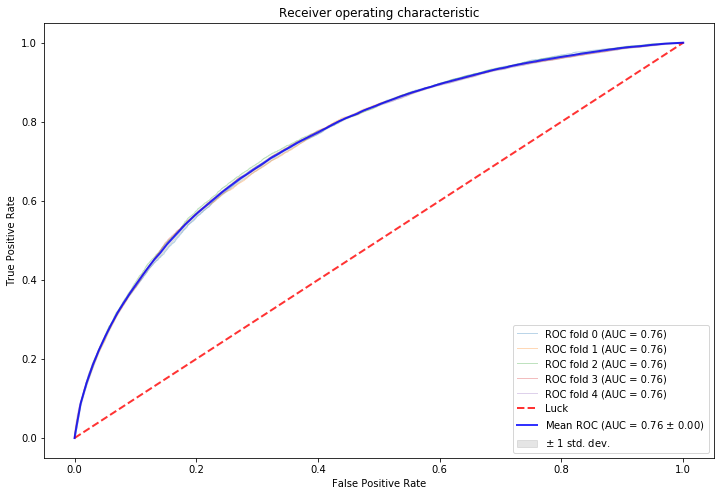

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1ef14cc0>)

In [52]:
plot_roc_curve(fprs_xgb_opt, tprs_xgb_xgb_opt)